**Amaç:** Basit bir model ile referans skor (Benchmark) oluşturmak.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import train_test_split
import joblib
import os

pd.set_option('display.max_columns', None) #ayar
sns.set_style("whitegrid")

data_path = '../data/processed/sensor_cleaned.csv'

if os.path.exists(data_path):
    df = pd.read_csv(data_path, parse_dates=['timestamp'], index_col='timestamp') #zaman serisi formatında
    print(f"Veri Yüklendi. Boyut: {df.shape}")
else:
    raise FileNotFoundError("Lütfen önce 01_EDA notebook'unu çalıştırın.")

# Machine Status'u kontrol et
print(df['machine_status'].value_counts())

Veri Yüklendi. Boyut: (220320, 52)
machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


**Önemli adım:** Sadece "kırılma anını" tahmin etmek yerine, kırılmadan önceki 24 saati "Tehlikeli Durum" (1) olarak etiketleyeceğiz. 
- Arıza (BROKEN) anından geriye doğru 'window_hours' kadar süreyi 1, diğer zamanları 0 olarak etiketler. RECOVERING (Tamir) süreci veri setinden çıkarılır.

In [3]:
def create_target_variable(df, window_hours=24):
    
    df_labeled = df.copy()
    
    df_labeled['y'] = 0   # hedef değiken(y) = 0 normal
    
    broken_indices = df_labeled[df_labeled['machine_status'] == 'BROKEN'].index  
    
    print(f"Toplam Arıza Sayısı: {len(broken_indices)}")
    
    
    for fail_time in broken_indices:
        start_time = fail_time - pd.Timedelta(hours=window_hours)
        
        mask = (df_labeled.index >= start_time) & (df_labeled.index <= fail_time) # tüm satırlar 1 (arıza yaklaşıyor demek)
        df_labeled.loc[mask, 'y'] = 1
        
    print("Etiketleme tamamlandı.")
    
    df_final = df_labeled[df_labeled['machine_status'] != 'RECOVERING'].copy() # modeli düzgün eğitmek için recovery çıkartıldı
    
    df_final = df_final.drop(columns=['machine_status'])
    
    return df_final

df_model = create_target_variable(df, window_hours=24)

print("\n--- Yeni Hedef Değişken Dağılımı ---")
print(df_model['y'].value_counts())
print(f"Pozitif Sınıf Oranı: %{df_model['y'].mean() * 100:.2f}")

Toplam Arıza Sayısı: 7
Etiketleme tamamlandı.

--- Yeni Hedef Değişken Dağılımı ---
y
0    195756
1     10087
Name: count, dtype: int64
Pozitif Sınıf Oranı: %4.90


- Veriyi train ve test olmak üzere zamana göre sıralı tutarak ayırıyoruz. Geleceği eğitime katamayız.

## Karşılaşılan sorun ##

Baseline modelin ilk denemesinde test seti üzerinde yüzde yüz doğruluk skoru elde ettik. Bu derece düzgün doğruluk oranının olması iyi bir durum değil. Standart yüzde 20 oranında zaman bazlı bölme yapıldığında, veri setinde nadir görülen tüm arıza(7) olaylarının train setinde kaldığı anlaşıldı. test setinin tamamı da normal verilerden oluştuğu için arıza yakalama başarısını ölçemedik. Peki bu durumu nasıl çözüm üretiriz?

## Uygulanan Çözüm ##

Modelin başarısını doğru bir şekilde ölçebilmek için test setinin de arıza verisi içermesi gerekir. Burdan yola çıkarak arıza olayının tarihleri analiz edildi. Son arızanın tarihi bulundu. ve kesme nıktası otomatik yüzde yerine son arızayı kapsayacak şekilde manuel olarak o tarihe çekildi.

Veriler karıştırılmadan, kronolojik sırayla ayrıldı. (zaman serisi projesi). Train son arızayı kapsayan tarih (örn 1 nisan) öncesi veriler. bu da geçmişteki 6 arızayı içerir. test seti belirlenen tarih sonrası veriler. son gerçekleşen 1 arıza ve o arızaya giden süreç içerir.

**Sonuç:** Bu strateji ile modelin, geçmiş arızalardan edindiği bilgileri kullanarak gelecekteki hiç görmediği bir arızayı tahmin edip edemeyeceği simüle edildi.


In [9]:
broken_dates = df[df['machine_status'] == 'BROKEN'].index
print("Arıza Tarihleri:\n", broken_dates)

if len(broken_dates) > 0:
    last_failure = broken_dates[-1] 
    split_date = last_failure - pd.Timedelta(days=5) # son arızadan beş gün önce. son arıza kesin olarak test setinde
else:
    # Hiç arıza yoksa standart %20
    split_date = df_model.index.max() - pd.Timedelta(days=30)

print(f"\nSeçilen Kesme Tarihi (Split Date): {split_date}")

X = df_model.drop(columns=['y', 'machine_status'], errors='ignore') 
y = df_model['y']

X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

print(f"Train Boyutu: {X_train.shape}, Test Boyutu: {X_test.shape}")
print(f"Test Setindeki '1' (Arıza) Sayısı: {y_test.sum()}")

Arıza Tarihleri:
 DatetimeIndex(['2018-04-12 21:55:00', '2018-04-18 00:30:00',
               '2018-05-19 03:18:00', '2018-05-25 00:30:00',
               '2018-06-28 22:00:00', '2018-07-08 00:11:00',
               '2018-07-25 14:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

Seçilen Kesme Tarihi (Split Date): 2018-07-20 14:00:00
Train Boyutu: (144838, 51), Test Boyutu: (61005, 51)
Test Setindeki '1' (Arıza) Sayısı: 1441


- Hızlı ve güçlü bir Random Forest ile "Feature Engineering" yapmadan ne kadar başarılı olduğumuza bakıyoruz.

Model eğitiliyor... (Bu işlem 1-2 dakika sürebilir)
Eğitim tamamlandı.

--- Sınıflandırma Raporu ---


d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\wastewater-predictive-maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     59564
           1       0.00      0.00      0.00      1441

    accuracy                           0.98     61005
   macro avg       0.49      0.50      0.49     61005
weighted avg       0.95      0.98      0.96     61005


--- Confusion Matrix ---


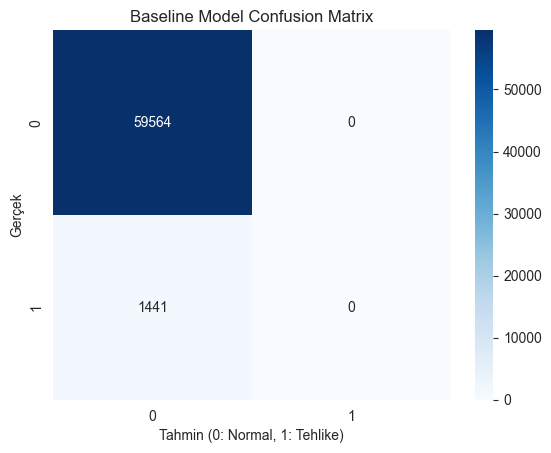

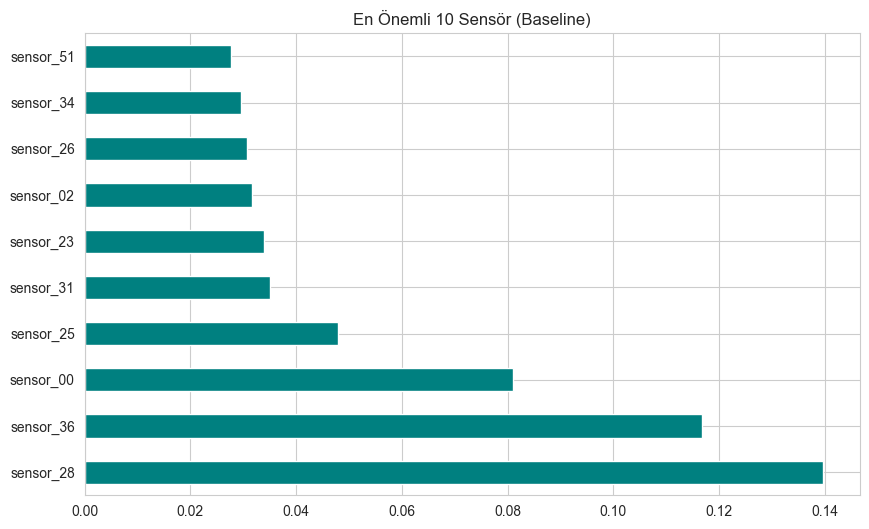

In [8]:
print("Model eğitiliyor... (Bu işlem 1-2 dakika sürebilir)")

rf_model = RandomForestClassifier(n_estimators=100, 
                                  class_weight='balanced',  # Class_weight='balanced' diyoruz çünkü hala 0'lar 1'lerden çok fazla.
                                  random_state=42, 
                                  n_jobs=-1)

rf_model.fit(X_train, y_train)
print("Eğitim tamamlandı.")

y_pred = rf_model.predict(X_test)

print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Baseline Model Confusion Matrix")
plt.xlabel("Tahmin (0: Normal, 1: Tehlike)")
plt.ylabel("Gerçek")
plt.show()

# Feature Importance (Hangi sensörler önemli?)
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
plt.figure(figsize=(10, 6))
importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("En Önemli 10 Sensör (Baseline)")
plt.show()

- Oluşturduğumuz modeli sonra kullanmak üzere kaydedelim

In [11]:
os.makedirs('../models', exist_ok=True)
joblib.dump(rf_model, '../models/baseline_rf_model.pkl')
print("Baseline model 'models/baseline_rf_model.pkl' olarak kaydedildi.")

Baseline model 'models/baseline_rf_model.pkl' olarak kaydedildi.


## Sonuçlar ve Kararlar

### 1. Performans Analizi (Neden Başarısız Olduk?)
* **Recall (Duyarlılık): 0.00** — Model, test setindeki **1441 adet** "Arıza Riski" (Label=1) durumunun **hiçbirini** yakalayamadı.
* **Precision (Kesinlik): Tanımsız (0.0)** — Model, risk almaktan kaçınarak tüm verilere "Normal" (0) tahmini yaptı. Hiçbir "1" tahmini yapmadığı için `Division by Zero` uyarısı alındı.
* **Accuracy (Doğruluk): %98** — Bu metrik **yanıltıcıdır**. Veri seti dengesiz olduğu için model sadece çoğunluk sınıfını (Normal) tahmin ederek yüksek skor elde etti ancak iş problemini (Arıza Tespiti) çözemedi.

### 2. Validasyon Stratejisi Başarısı
* İlk denemede test setine hiç arıza düşmemesi sorunu, **Zaman Bazlı Ayrım** stratejisi manuel olarak düzeltilerek çözüldü.
* Test setinde `Support: 1441` (Sınıf 1) görülmesi, validasyon ortamımızın artık sağlıklı olduğunu ve gelecekteki bir arızayı simüle edebildiğimizi kanıtlıyor.

### 3. Kritik Karar: Feature Engineering Şart
Bu sonuçlar matematiksel olarak kanıtlamıştır ki: **Ham sensör verisi (anlık değerler), arızayı önceden tahmin etmek için yeterli değildir.**

**Hedef:** Bir sonraki notebook'ta Recall skorunu 0.00'dan yukarıya taşımak.